# Tanzania Water - Ternery Classifier Problem
***
***

This notebook contains the working code for the models and vizualisations used for the project. The aim of the project is to predict the functionality status ('functional', 'functional needs repair', and 'non-functional') of water wells in Tanzania. The dataset used is the 'df_clean.csv' file located in the repository, which is a cleaned version of the data obtained from the Driven Data website. 

First, a baseline model was created using a Decision Tree Classifier. This was then compared to a three other models: a Random Forest Classifier, an Adaptive Boosting Classifier, and a Gradient Boosting Classifier.

# Summary of Results

# INSERT RESULTS SUMMARY HERE!!!

In [469]:
# generating the confusion matrix visualisation using Dtrimachi's function
# dtc_cm_cats = ['functional', 'functional needs repair', 'non functional']
# make_confusion_matrix(dtc_cm, figsize=(12,10), categories=dtc_cm_cats, title='DTC Confusion Matrix')

First, the relevant libraries and functions are imported and defined, and the dataframe is read and inspected.

In [470]:
# importing relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
skf = StratifiedKFold(n_splits=5,random_state=16,shuffle=True)

%matplotlib inline

In [471]:
# defining relevant functions for later use
def score_plotter(model,
                  training_set_X,
                  training_set_y,
                  validation_set_X,
                  validation_set_y,
                  model_name=None):
    
    """
    This function takes in a machine learning model and outputs a visialisation of the ROC curve,
    along with the AUC score for each of the classes. It is intended to be used as a summary evaluator
    for the models in this project.
    
    Args:
        model: the model to be evaluated
        training_set_X: the training set features
        training_set_y: the training set target
        validation_set_X: the validation set features
        validation_set_y: the validation set target
        model_name: the name of the type of model (eg: Random Forest Classifier), defaults to None
    """    
    
    # generating predictions   
    model_pred_train = model.predict(X_train)
    model_pred_proba_train = model.predict_proba(X_train)
    model_pred_val = model.predict(X_val)
    model_pred_proba_val = model.predict_proba(X_val)
    # converting targets to dummy variables   
    y_train_d = np.array(pd.get_dummies(y_train))
    y_val_d = np.array(pd.get_dummies(y_val))
    
    # generating roc curves for each class  
    fpr_0, tpr_0, thresholds_0 = roc_curve(y_val_d[:,0], model_pred_proba_val[:,0])
    fpr_1, tpr_1, thresholds_1 = roc_curve(y_val_d[:,1], model_pred_proba_val[:,1])
    fpr_2, tpr_2, thresholds_2 = roc_curve(y_val_d[:,2], model_pred_proba_val[:,2])
    
    # computing AUC scores for each class
    auc_0 = roc_auc_score(y_val_d[:,0], model_pred_proba_val[:,0])
    auc_1 = roc_auc_score(y_val_d[:,1], model_pred_proba_val[:,1])
    auc_2 = roc_auc_score(y_val_d[:,2], model_pred_proba_val[:,2])
    
    # generating plot figure
    plt.figure(figsize=(8,8))
    
    # plotting ROC curves for each class
    plt.plot([0, 1], [0, 1], label='Chance line', color='gray', linestyle='--')   
    plt.plot(fpr_0, tpr_0, label=f'Functional: AUC = {round(auc_0,3)}',color='seagreen')
    plt.plot(fpr_1, tpr_1, label=f'Functional needs repair: AUC = {round(auc_1,3)}',color='goldenrod')
    plt.plot(fpr_2, tpr_2, label=f'Non functional: AUC = {round(auc_2,3)}',color='maroon')
    
    # plot formatting (including mean AUC for the three classes)
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.legend(loc=4)
    plt.title(f'{model_name}: mean AUC = {round((auc_0+auc_1+auc_2)/3,3)}')
    plt.show()

In [472]:
# importing relevant functions
from functions.confusion_matrix import make_confusion_matrix

Note that the ***make_confusion_matrix*** function for visualising confusion matrices was found on the web and not created by the project team. Credit in its entirity is due to GitHub user DTrimarchi10. Please see https://github.com/DTrimarchi10/confusion_matrix

In [473]:
# loading and reading data
df = pd.read_csv('df_clean.csv')
df = df.drop('Unnamed: 0', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   amount_tsh        59400 non-null  float64
 1   funder            59400 non-null  object 
 2   installer         59400 non-null  object 
 3   gps_height        59400 non-null  float64
 4   longitude         59400 non-null  float64
 5   latitude          59400 non-null  float64
 6   basin             59400 non-null  object 
 7   population        59400 non-null  float64
 8   permit            59400 non-null  object 
 9   extraction_type   59400 non-null  object 
 10  management        59400 non-null  object 
 11  management_group  59400 non-null  object 
 12  payment           59400 non-null  object 
 13  quality_group     59400 non-null  object 
 14  quantity          59400 non-null  object 
 15  source            59400 non-null  object 
 16  waterpoint_type   59400 non-null  object

Next, the data is split into predictor and target variables, before dummy variables are encoded for all categorical variables.

In [474]:
# splitting target and predictor variables into separate dataframes
y = df['status_group']
X = df.drop('status_group', axis=1)

In [475]:
# creating dummy columns for categoricals
X_d = pd.get_dummies(X)

Finally, the data is split into training, validation, and testing sets.

In [476]:
X_tv, X_test, y_tv, y_test = train_test_split(X_d, y, test_size=0.25, random_state=16)

In [477]:
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=0.25, random_state=16)

# Trial 1: Baseline

The baseline model will be a Decision Tree Classifier, run with no hyperparameter optimisation.

In [478]:
# importing relevant libraries
from sklearn.tree import DecisionTreeClassifier

In [479]:
# creating DTC and fitting to training data
dtc = DecisionTreeClassifier(random_state=16)
dtc_model = dtc.fit(X_train,y_train)

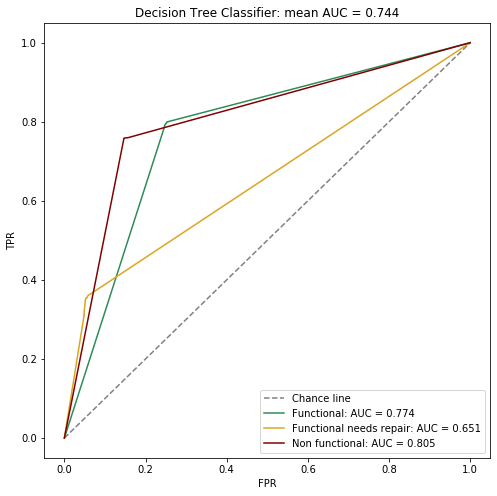

In [480]:
# generating the evaluation output for the baseline model using the score_plotter function defined above.
score_plotter(dtc_model,X_train,y_train,X_val,y_val,model_name='Decision Tree Classifier')

The baseline model does not perform particularly well, as expected. The AUC scores for the three classes are:

- Functional: 0.774
- Functional needs repair: 0.651
- Non functional: 0.805

And the mean AUC score across the three classes is 0.744.

# Trial 2: Random Forest Classifier

The next trial uses a Random Forest Classifier with hyperparameter optimisation.

In [481]:
from sklearn.ensemble import RandomForestClassifier

In [482]:
forest = RandomForestClassifier(random_state=16)
rfc_model = forest.fit(X_train, y_train)

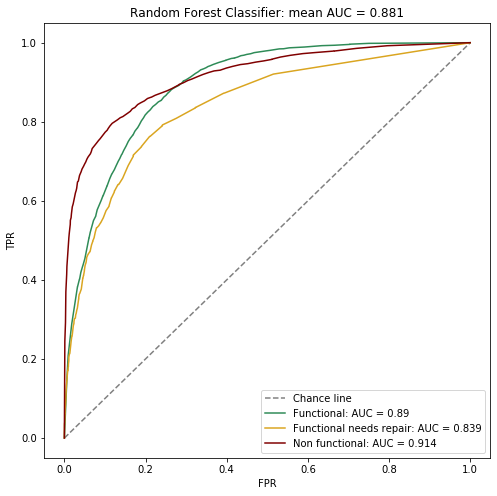

In [483]:
score_plotter(rfc_model,X_train,y_train,X_val,y_val,model_name='Random Forest Classifier')

The RFC performs significantly better than the baseline immediately. The AUC scores for the three classes are:

- Functional: 0.890
- Functional needs repair: 0.839
- Non functional: 0.914

And the mean AUC score across the three classes is 0.881.

### RFC: Search 1

In [513]:
%%time
# search 1 using the following hyperparameter ranges:
param_grid_rfc_search_1 = {'max_depth':[5,25,40],
                           'min_samples_leaf':[5,50,500],
                           'bootstrap': [True, False]}

opt_model_rfc_search_1 = GridSearchCV(rfc_model,
                                      param_grid_rfc_search_1,
                                      cv=skf,
                                      scoring='accuracy',
                                      return_train_score=True,
                                      n_jobs=-1,
                                      verbose=1)

# fitting the optimised model
opt_model_rfc_search_1.fit(X_train,y_train)

# saving the best estimator
best_rfc_model_search_1 = opt_model_rfc_search_1.best_estimator_

# extracting best hyperparameter values
print('Best Hyperparameters:')
print('---------------------')
print('max_depth:',best_rfc_model_search_1.get_params()['max_depth'])
print('min_samples_leaf:',best_rfc_model_search_1.get_params()['min_samples_leaf'])
print('bootstrap:',best_rfc_model_search_1.get_params()['bootstrap'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.0min finished


CPU times: user 10.6 s, sys: 235 ms, total: 10.8 s
Wall time: 3min 12s


From the above we see that the parameters for ***max_depth*** and ***min_samples_leaf*** are on the edges of the ranges. The result for the ***bootstrap*** hyperparameter is 'False', therefore it will be set to 'False' in the next search.

### RFC: Search 2

In [527]:
%%time
param_grid_rfc_search_2 = {'max_depth':[40,80,120],
                           'min_samples_leaf':[1,2,3],
                           'bootstrap':[False]}

opt_model_rfc_search_2 = GridSearchCV(rfc_model,
                                      param_grid_rfc_search_2,
                                      cv=skf,
                                      scoring='accuracy',
                                      return_train_score=True,
                                      n_jobs=-1,
                                      verbose=1)

opt_model_rfc_search_2.fit(X_train,y_train)
best_rfc_model_search_2 = opt_model_rfc_search_2.best_estimator_

# extracting best hyperparameter values
print('Best Hyperparameters:')
print('---------------------')
print('max_depth:',best_rfc_model_search_2.get_params()['max_depth'])
print('min_samples_leaf:',best_rfc_model_search_2.get_params()['min_samples_leaf'])
print('bootstrap:',best_rfc_model_search_2.get_params()['bootstrap'])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.6min finished


CPU times: user 11.8 s, sys: 239 ms, total: 12 s
Wall time: 3min 45s


From the above we see that the parameters for ***max_depth*** and ***min_samples_leaf*** are both within the ranges. The value for ***min_samples_leaf*** is in the middle of the range, with no other options, and is therefore deemed optimal. The search will continue to optimise ***max_depth***.

### RFC: Search 3

In [537]:
%%time
param_grid_rfc_search_3 = {'max_depth':[70,80,90],
                           'min_samples_leaf':[2],
                           'bootstrap':[False]}

opt_model_rfc_search_3 = GridSearchCV(rfc_model,
                                      param_grid_rfc_search_3,
                                      cv=skf,
                                      scoring='accuracy',
                                      return_train_score=True,
                                      n_jobs=-1,
                                      verbose=1)

opt_model_rfc_search_3.fit(X_train,y_train)
best_rfc_model_search_3 = opt_model_rfc_search_3.best_estimator_

# extracting best hyperparameter values
print('Best Hyperparameters:')
print('---------------------')
print('max_depth:',best_rfc_model_search_3.get_params()['max_depth'])
print('min_samples_leaf:',best_rfc_model_search_3.get_params()['min_samples_leaf'])
print('bootstrap:',best_rfc_model_search_3.get_params()['bootstrap'])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.1min finished


CPU times: user 11.3 s, sys: 158 ms, total: 11.5 s
Wall time: 1min 19s


The search will continue in the following sections for the optimal value for ***max_depth***...

### RFC: Search 4

In [539]:
%%time
param_grid_rfc_search_4 = {'max_depth':[60,70,80],
                           'min_samples_leaf':[2],
                           'bootstrap':[False]}

opt_model_rfc_search_4 = GridSearchCV(rfc_model,
                                      param_grid_rfc_search_4,
                                      cv=skf,
                                      scoring='accuracy',
                                      return_train_score=True,
                                      n_jobs=-1,
                                      verbose=1)

opt_model_rfc_search_4.fit(X_train,y_train)
best_rfc_model_search_4 = opt_model_rfc_search_4.best_estimator_

# extracting best hyperparameter values
print('Best Hyperparameters:')
print('---------------------')
print('max_depth:',best_rfc_model_search_4.get_params()['max_depth'])
print('min_samples_leaf:',best_rfc_model_search_4.get_params()['min_samples_leaf'])
print('bootstrap:',best_rfc_model_search_4.get_params()['bootstrap'])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.1min finished


CPU times: user 11.4 s, sys: 180 ms, total: 11.6 s
Wall time: 1min 17s


### RFC: Search 5

In [543]:
%%time
param_grid_rfc_search_5 = {'max_depth':[40,45,50],
                           'min_samples_leaf':[2],
                           'bootstrap':[False]}

opt_model_rfc_search_5 = GridSearchCV(rfc_model,
                                      param_grid_rfc_search_5,
                                      cv=skf,
                                      scoring='accuracy',
                                      return_train_score=True,
                                      n_jobs=-1,
                                      verbose=1)

opt_model_rfc_search_5.fit(X_train,y_train)
best_rfc_model_search_5 = opt_model_rfc_search_5.best_estimator_

# extracting best hyperparameter values
print('Best Hyperparameters:')
print('---------------------')
print('max_depth:',best_rfc_model_search_5.get_params()['max_depth'])
print('min_samples_leaf:',best_rfc_model_search_5.get_params()['min_samples_leaf'])
print('bootstrap:',best_rfc_model_search_5.get_params()['bootstrap'])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.3min finished


Best Hyperparameters:
---------------------
max_depth: 45
min_samples_leaf: 2
bootstrap: False
CPU times: user 11.4 s, sys: 187 ms, total: 11.6 s
Wall time: 1min 28s


### RFC: Search 6

In [544]:
%%time
param_grid_rfc_search_6 = {'max_depth':[42,45,47],
                           'min_samples_leaf':[2],
                           'bootstrap':[False]}

opt_model_rfc_search_6 = GridSearchCV(rfc_model,
                                      param_grid_rfc_search_6,
                                      cv=skf,
                                      scoring='accuracy',
                                      return_train_score=True,
                                      n_jobs=-1,
                                      verbose=1)

opt_model_rfc_search_6.fit(X_train,y_train)
best_rfc_model_search_6 = opt_model_rfc_search_6.best_estimator_

# extracting best hyperparameter values
print('Best Hyperparameters:')
print('---------------------')
print('max_depth:',best_rfc_model_search_6.get_params()['max_depth'])
print('min_samples_leaf:',best_rfc_model_search_6.get_params()['min_samples_leaf'])
print('bootstrap:',best_rfc_model_search_6.get_params()['bootstrap'])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.2min finished


Best Hyperparameters:
---------------------
max_depth: 42
min_samples_leaf: 2
bootstrap: False
CPU times: user 11.3 s, sys: 176 ms, total: 11.5 s
Wall time: 1min 24s


### RFC: Search 7

In [545]:
%%time
param_grid_rfc_search_7 = {'max_depth':[41,42,43],
                           'min_samples_leaf':[2],
                           'bootstrap':[False]}

opt_model_rfc_search_7 = GridSearchCV(rfc_model,
                                      param_grid_rfc_search_7,
                                      cv=skf,
                                      scoring='accuracy',
                                      return_train_score=True,
                                      n_jobs=-1,
                                      verbose=1)

opt_model_rfc_search_7.fit(X_train,y_train)
best_rfc_model_search_7 = opt_model_rfc_search_7.best_estimator_

# extracting best hyperparameter values
print('Best Hyperparameters:')
print('---------------------')
print('max_depth:',best_rfc_model_search_7.get_params()['max_depth'])
print('min_samples_leaf:',best_rfc_model_search_7.get_params()['min_samples_leaf'])
print('bootstrap:',best_rfc_model_search_7.get_params()['bootstrap'])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.2min finished


Best Hyperparameters:
---------------------
max_depth: 42
min_samples_leaf: 2
bootstrap: False
CPU times: user 11.4 s, sys: 174 ms, total: 11.5 s
Wall time: 1min 26s


The optimal value for ***max_depth*** has been located at 42. This search has therefore yielded the best model.

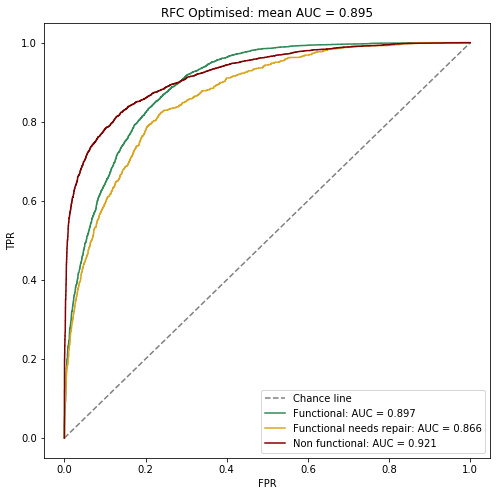

In [548]:
best_rfc_model = best_rfc_model_search_7
score_plotter(best_rfc_model,X_train,y_train,X_val,y_val,model_name='RFC Optimised')

The hyperparameter-optimised RFC improves on the original RFC. The AUC scores for the three classes have increased as follows:

- Functional: from 0.890 to **0.897**
- Functional needs repair: from 0.839 to **0.866**
- Non functional: from 0.914 to **0.921**

And the mean AUC score across the three classes has increased from 0.881 to **0.895**.

# Trial 3: AdaBoost

The next trial uses an Adaptive Boost Classifier with hyperparameter optimisation.

In [485]:
from sklearn.ensemble import AdaBoostClassifier

In [486]:
abc = AdaBoostClassifier(random_state=16)
abc_model = abc.fit(X_train, y_train)

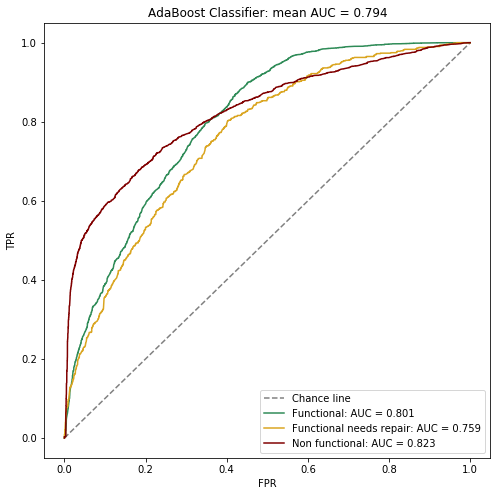

In [487]:
score_plotter(abc_model,X_train,y_train,X_val,y_val, model_name='AdaBoost Classifier')

The ABC performs significantly better than the baseline, but not quite as well as the RFC. The AUC scores for the three classes are:

- Functional: 0.801
- Functional needs repair: 0.759
- Non functional: 0.823

And the mean AUC score across the three classes is 0.794.

### ABC: Search 1

In [559]:
%%time
# search 1 using the following hyperparameter ranges:
param_grid_abc_search_1 = {'learning_rate':[lr/100 for lr in range(1,100+1,10)]}

opt_model_abc_search_1 = GridSearchCV(abc_model,
                                      param_grid_abc_search_1,
                                      cv=skf,
                                      scoring='accuracy',
                                      return_train_score=True,
                                      n_jobs=-1,
                                      verbose=1)

# fitting the optimised model
opt_model_abc_search_1.fit(X_train,y_train)

# saving the best estimator
best_abc_model_search_1 = opt_model_abc_search_1.best_estimator_

# extracting best hyperparameter values
print('Best Hyperparameters:')
print('---------------------')
print('learning_rate:',best_abc_model_search_1.get_params()['learning_rate'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished


Best Hyperparameters:
---------------------
learning_rate: 0.61
CPU times: user 5.65 s, sys: 168 ms, total: 5.82 s
Wall time: 2min


### ABC: Search 2

In [560]:
%%time
param_grid_abc_search_2 = {'learning_rate':[0.55,0.58,0.6,0.62,0.64,0.66,0.68]}

opt_model_abc_search_2 = GridSearchCV(abc_model,
                                      param_grid_abc_search_2,
                                      cv=skf,
                                      scoring='accuracy',
                                      return_train_score=True,
                                      n_jobs=-1,
                                      verbose=1)

opt_model_abc_search_2.fit(X_train,y_train)

best_abc_model_search_2 = opt_model_abc_search_2.best_estimator_

# extracting best hyperparameter values
print('Best Hyperparameters:')
print('---------------------')
print('learning_rate:',best_abc_model_search_2.get_params()['learning_rate'])

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.4min finished


Best Hyperparameters:
---------------------
learning_rate: 0.64
CPU times: user 5.6 s, sys: 180 ms, total: 5.78 s
Wall time: 1min 28s


### ABC: Search 3

In [561]:
%%time
param_grid_abc_search_3 = {'learning_rate':[0.62,0.63,0.64,0.65,0.66]}

opt_model_abc_search_3 = GridSearchCV(abc_model,
                                      param_grid_abc_search_3,
                                      cv=skf,
                                      scoring='accuracy',
                                      return_train_score=True,
                                      n_jobs=-1,
                                      verbose=1)

opt_model_abc_search_3.fit(X_train,y_train)

best_abc_model_search_3 = opt_model_abc_search_3.best_estimator_

# extracting best hyperparameter values
print('Best Hyperparameters:')
print('---------------------')
print('learning_rate:',best_abc_model_search_3.get_params()['learning_rate'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   57.9s finished


Best Hyperparameters:
---------------------
learning_rate: 0.64
CPU times: user 5.11 s, sys: 231 ms, total: 5.34 s
Wall time: 1min 2s


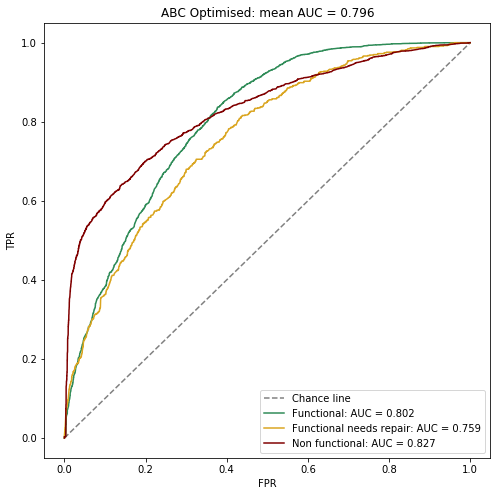

In [562]:
best_abc_model = best_abc_model_search_3
score_plotter(best_abc_model,X_train,y_train,X_val,y_val,model_name='ABC Optimised')

The hyperparameter-optimised ABC improves slightly on the original ABC. The AUC scores for the three classes have increased as follows:

- Functional: from 0.801 to **0.802**
- Functional needs repair: no change from 0.759 to **0.759**
- Non functional: from 0.823 to **0.827**

And the mean AUC score across the three classes has increased from 0.794 to **0.796**.